In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# These are the advanced modules
# ======================>>>>>>>>>>>>>>>>>>>>>>>>================================================
from sklearn.metrics import mean_squared_error # To compute mean squared error
from sklearn.model_selection import train_test_split # To split the data into tarin and test set
from pmdarima import auto_arima # To find optimum values for p, d, and q for arima model
from statsmodels.tsa.seasonal import seasonal_decompose # To plot decomposition plot
from statsmodels.tsa.stattools import adfuller # To conduct augmented dickey-fuller test
import statsmodels.api as sm # To create SARIMAX model

In [2]:
# Let's read in unit sale data
df = pd.read_excel("unitSoldByDate.xlsx")
df.head()

,date,Be-a.co.uk,Brentwood Open learning College,CPD Courses,Centre of Excellence,Course Gate,Euston College,Excel with Business,Janets,OfCourse,...,ProTrainings Europe Limited,1 Training,Course Cloud,Skill Up,The Teachers Training,International Open Academy,Mandatory Compliance,Simply Cert,Institute of Beauty and Makeup,The Animal Care
0,2020-01-27,0,0,0,0,0.0,0.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-28,73,92,118,21,83.0,1.0,28,90,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-29,79,77,126,10,112.0,1.0,19,78,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-30,83,86,166,22,110.0,1.0,20,86,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-31,111,161,218,20,116.0,2.0,26,123,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We would like to predict unit sale for Beaco which is a quality course provider in UK (particularly in reed.co.uk)

In [3]:
# Let's extract the required variables. We are only interested in unit sale and date.
y = df.loc[:, ["date", "Be-a.co.uk"]]

# Rename columns to UnitSold
y.rename(columns={f"{y.iloc[:, -1].name}":"unitSold"}, inplace=1)

# Remove zeros(outliers)
y = y.loc[y.unitSold!=0, :].reset_index(drop=True)

# Remove missing values if any
y = y[y.unitSold.isna()==False]

# Set date as index
y.set_index("date", inplace=True)

# Let's look at the unit sale now
y.head()

,unitSold
date,
2020-01-28,73
2020-01-29,79
2020-01-30,83
2020-01-31,111
2020-02-01,51


In [4]:
# Let's have a look a the basic stats
y.describe().round(2)

,unitSold
count,315.00
mean,64.31
std,31.51
min,1.00
25%,41.00
50%,59.00
75%,81.50
max,178.00


#### So as it turns out, Beaco, on average sold over 64 units per day for 315 days.

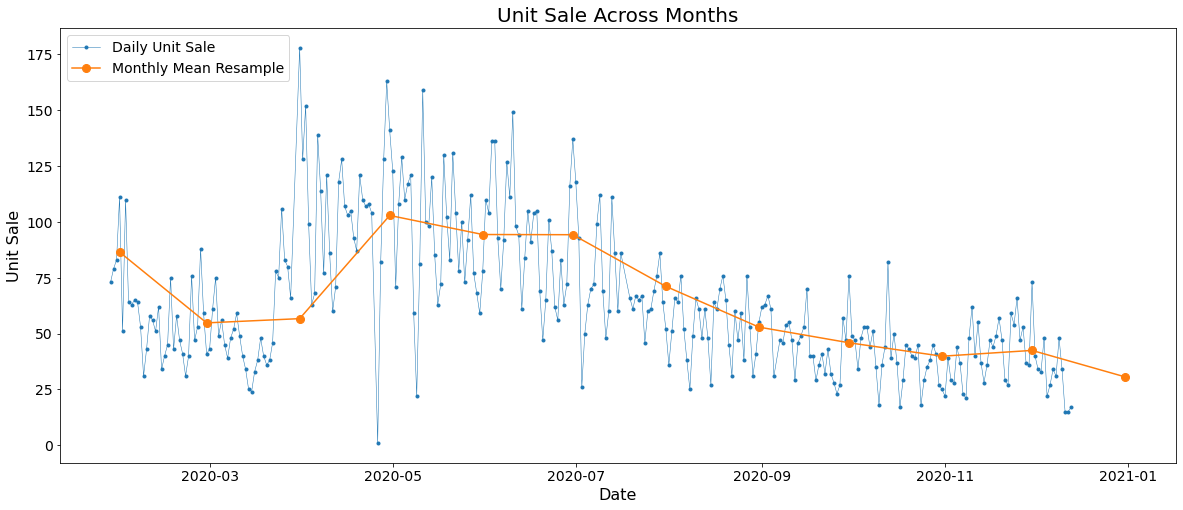

In [5]:
# Let's plot the unit sale against date
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.plot(y, marker=".", linestyle="-", linewidth=0.5, label="Daily Unit Sale")
ax.plot(y.resample("M").mean(), marker="o", markersize=8, linestyle="-", label="Monthly Mean Resample")
ax.set_title("Unit Sale Across Months", fontsize=20)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Unit Sale", fontsize=16)
ax.tick_params(axis="both", labelsize=14)
ax.legend(fontsize=14, loc="upper left")
plt.show()

#### April had the highest peak in terms of unit sale on Reed for the provider.

## Decomposition:
#### Let's decompose the data to view more of the complexity behind the linear visualization. Let's visualize our data using a method called time-series decomposition that allows us to decompose our time series into 4 distinct components: observed, trend, seasonality, and noise.

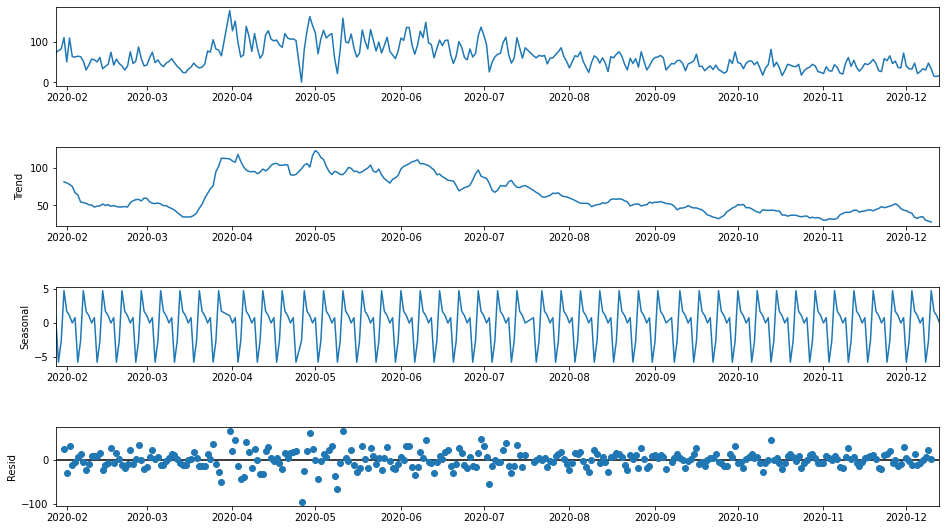

In [6]:
# Seasonality and trend
decomposition = seasonal_decompose(y, period=7, model="additive")  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)
plt.show()

#### There is no overall increasing or decreasing trend with strong sesonality.

## Check for Stationarity: We will check if the data is stationary using Augmented Dickey-Fuller test

In [7]:
# Stationary check, hypothesis
def checkForStationary(series):
    """series = column to check"""
    
    testResult = adfuller(series)
    print("ADF Test>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    labels = ["ADF Statistics", "p-value", "No. of Lags Used", "Number of Observations Used"]

    for value,label in zip(testResult, labels):
        print(label, value)

    if testResult[1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("Fail to reject H0 thereby data is non-stationary")

# Apply the function
checkForStationary(y)

ADF Test>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
ADF Statistics -1.1709584357234402
p-value 0.6859622682884755
No. of Lags Used 12
Number of Observations Used 302
Fail to reject H0 thereby data is non-stationary


### Here we go! P-value is way too greater than 0.05. Hence we have to accept null hypothesis since data is not stationary. So we would need to perform various data stationary methods like "detrending" and "differencing". Though our data is non-stationary, we won't apply any methods to make it statioinary, instead we will use auto arima function from module pmdarima to find "p", "d", and "q".

## Create train and test data:

In [8]:
# 75% will be used for trainin the model, and 25% will be used for evaluating the model
trainData, testData = train_test_split(y, test_size=0.25,  shuffle=False)

trainData.shape, testData.shape

((236, 1), (79, 1))

In [9]:
# Let's finnd p, q and d for arima model using auto_arima function from pmdarima module
autoarimaModel = auto_arima(trainData, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                             trace=True)

print(autoarimaModel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2153.925, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2216.113, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2208.311, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2176.343, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2214.125, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2148.436, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2192.880, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2147.764, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2177.833, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2148.471, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2149.549, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2146.092, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2151.467, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2124.869, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept

#### Looks like, the best value for p, d, and q are reqpectively 2, 1, and 3 for the train data. Let's build the model using the values we just find

In [10]:
# SARIMAX
sarimax = sm.tsa.statespace.SARIMAX(trainData,
                                order=(2, 1, 3),
                                seasonal_order=(2, 1, 3, 14),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                dynamic=True)
sarimaxFit = sarimax.fit()
sarimaxPredicted = sarimaxFit.predict(start=trainData.shape[0], end=y.shape[0]-1)

/home/faysal/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/faysal/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/faysal/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [11]:
# Creat a df off actual and predicted value and plot the values together
mergedPredicted = pd.DataFrame({
    "date":testData.index,
    "actual":testData.unitSold.values,
    "sarimaxPredicted":sarimaxPredicted
}).set_index("date")

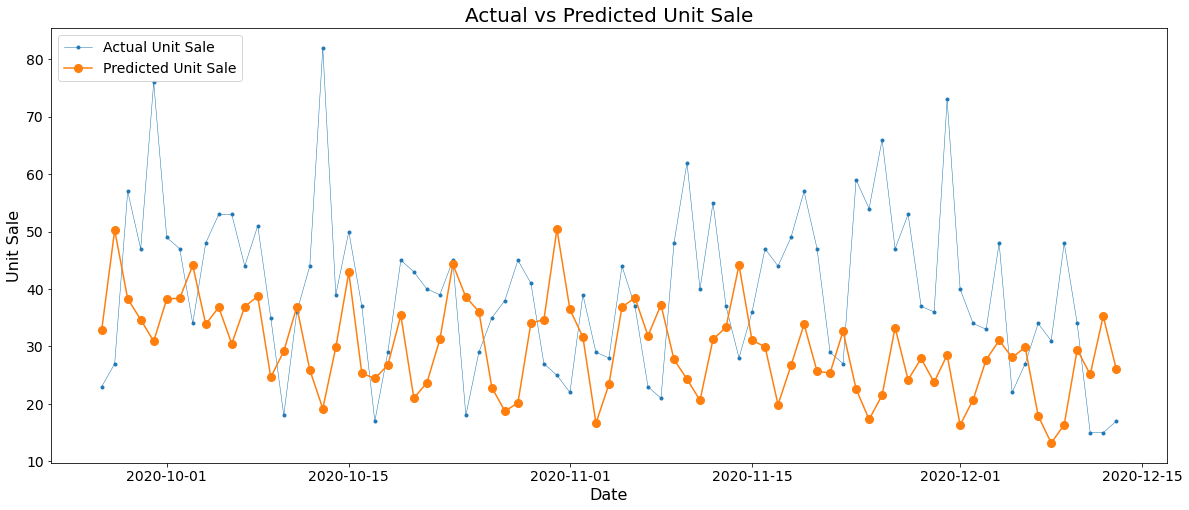

In [12]:
# Plot the actual value with predicted values
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.plot(mergedPredicted.actual, marker=".", linestyle="-", linewidth=0.5, label="Actual Unit Sale")
ax.plot(mergedPredicted.sarimaxPredicted, marker="o", markersize=8, linestyle="-", label="Predicted Unit Sale")
ax.set_title("Actual vs Predicted Unit Sale", fontsize=20)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Unit Sale", fontsize=16)
ax.tick_params(axis="both", labelsize=14)
ax.legend(fontsize=14, loc="upper left")
plt.show()

#### Not a very good prediction. This model underfits a lot at the end of Noverber. This can be eliminated using further hyperparameters optimization.

In [13]:
# Let's calculate mmodel's mean squared error
mse = mean_squared_error(y_true=testData, y_pred=sarimaxPredicted)
rmse = np.sqrt(mse).round(2)
rmse

19.55

In [14]:
# Make prediction on future data
futureDate = pd.date_range(start="2020-12-13", end="2020-12-31")
futurePred = sarimaxFit.predict(start=y.shape[0], end=y.shape[0]+18).to_frame().rename(columns={"predicted_mean":"arimaPred"})
futurePred["date"] = futureDate
futurePred = futurePred.set_index("date")
futurePred.head()

/home/faysal/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,arimaPred
date,
2020-12-13,25.764531
2020-12-14,11.810878
2020-12-15,17.425289
2020-12-16,28.079999
2020-12-17,31.260512


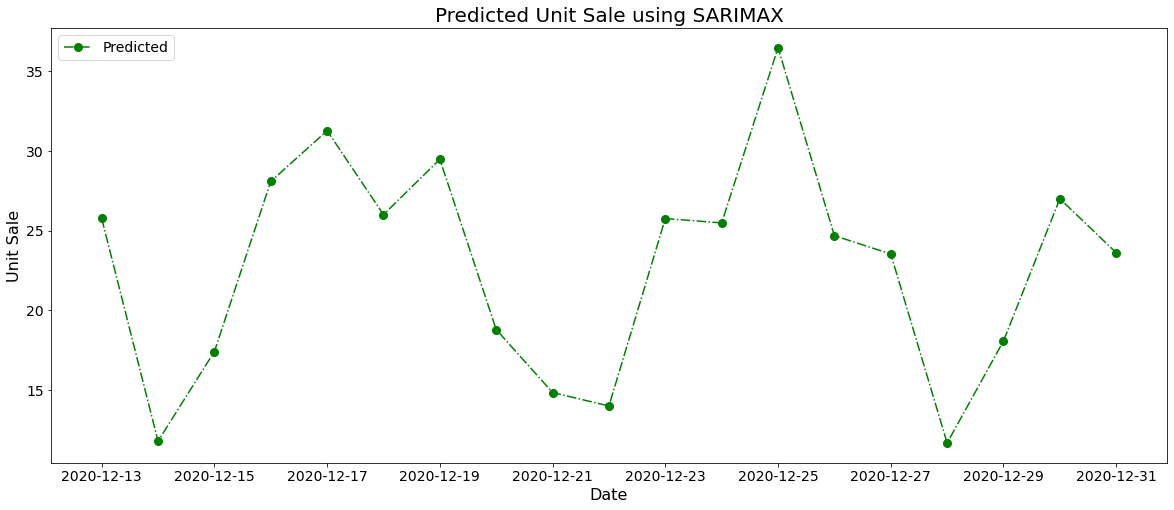

In [15]:
# Plot the predicted values
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.plot(futurePred.arimaPred, marker="o", markersize=8, linestyle="-.", label="Predicted", color="g")
ax.set_title("Predicted Unit Sale using SARIMAX", fontsize=20)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Unit Sale", fontsize=16)
ax.tick_params(axis="both", labelsize=14)
ax.legend(fontsize=14, loc="upper left")
plt.show()